# 1. Data collection

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('C:\\Users\\chinn\\OneDrive\\Desktop\\train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 2. EDA and Data manipulation

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
def get_missingval_percent(df):
    for i in range(len(df.columns)):
        print('Missing values percentage of column',df.columns[i],': ', (df[df.columns[i]].isna().sum()/len(df))*100)
        
get_missingval_percent(df)

Missing values percentage of column PassengerId :  0.0
Missing values percentage of column Survived :  0.0
Missing values percentage of column Pclass :  0.0
Missing values percentage of column Name :  0.0
Missing values percentage of column Sex :  0.0
Missing values percentage of column Age :  19.865319865319865
Missing values percentage of column SibSp :  0.0
Missing values percentage of column Parch :  0.0
Missing values percentage of column Ticket :  0.0
Missing values percentage of column Fare :  0.0
Missing values percentage of column Cabin :  77.10437710437711
Missing values percentage of column Embarked :  0.22446689113355783


c:\Users\chinn\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Fare'>

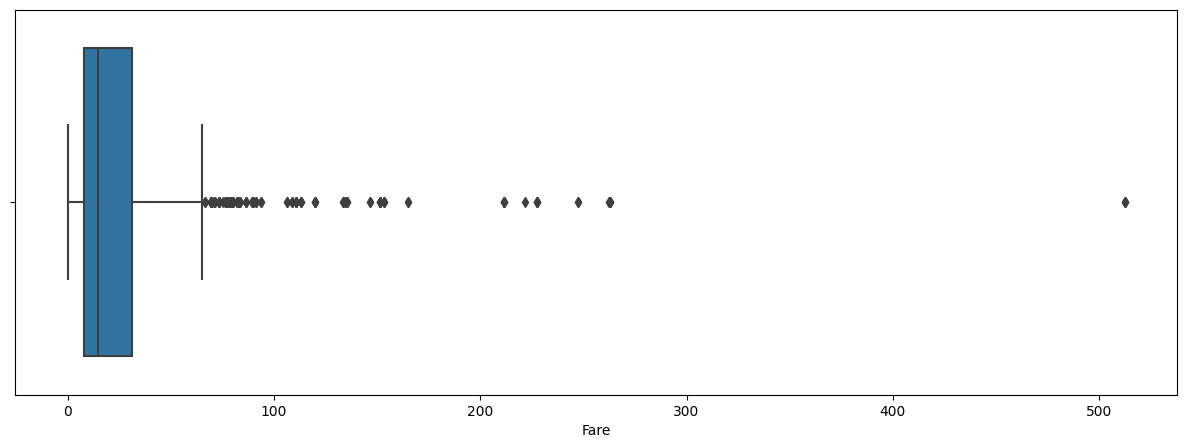

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt 

plt.figure(figsize = (15,5))
sns.boxplot(df['Fare'])

<AxesSubplot:>

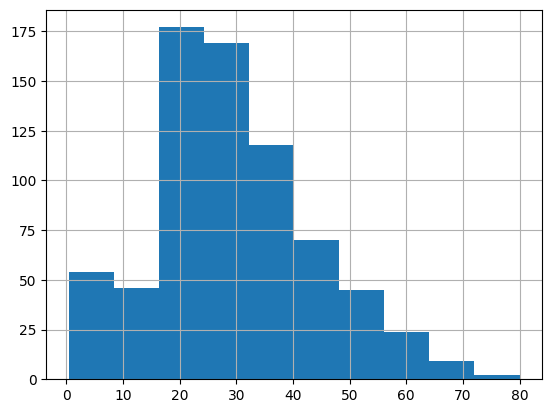

In [7]:
df['Age'].hist()

In [8]:
df['Age'].isna().sum()

177

In [9]:
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Age'].isna().sum()

0

<AxesSubplot:>

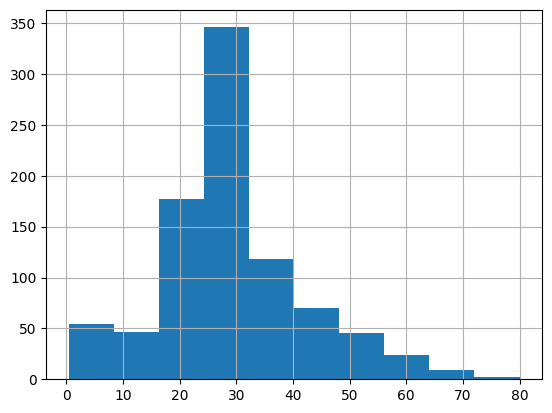

In [10]:
df['Age'].hist()

In [11]:
df.drop(['Cabin'], inplace=True, axis=1)
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked'],
      dtype='object')

In [12]:
print(df.Embarked.isna().sum())

2


<AxesSubplot:>

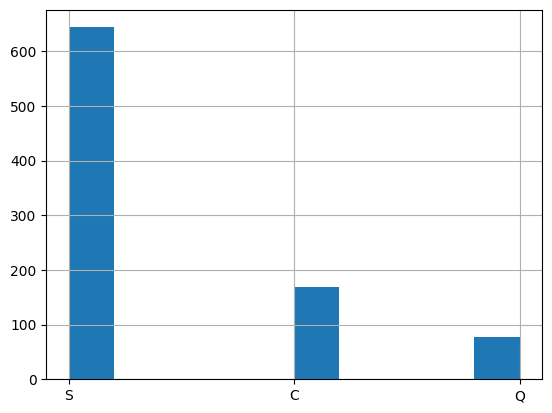

In [13]:
df['Embarked'].hist()

In [14]:
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
print('Null values: ', df['Embarked'].isna().sum())


Null values:  0


In [15]:
df.pivot_table(values='Survived', index='Embarked', columns=['Sex'])

Sex,female,male
Embarked,,
C,0.876712,0.305263
Q,0.750000,0.073171
S,0.692683,0.174603


<AxesSubplot:xlabel='Embarked'>

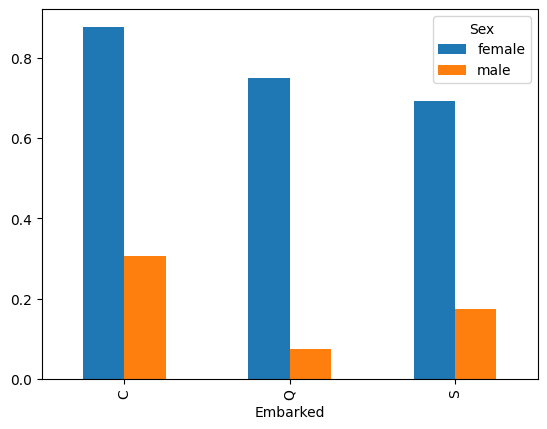

In [16]:
df.pivot_table(values='Survived', index='Embarked', columns=['Sex']).plot(kind='bar')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


In [18]:
df['Ticket'].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

In [19]:
dummy = pd.get_dummies(df.Sex)
dummy

,female,male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1
...,...,...
886,0,1
887,1,0
888,1,0
889,0,1


In [20]:
df.drop('Sex', inplace=True, axis =1)
df = pd.concat([df, dummy],axis=1)
df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Embarked,female,male
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,S,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C,1,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,S,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,S,1,0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,S,0,1


In [21]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df['Embarked'] = le.fit_transform(df['Embarked'])
df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Embarked,female,male
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,2,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,2,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,2,1,0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,2,0,1


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Embarked     891 non-null    int32  
 10  female       891 non-null    uint8  
 11  male         891 non-null    uint8  
dtypes: float64(2), int32(1), int64(5), object(2), uint8(2)
memory usage: 68.0+ KB


In [23]:
df.drop(['Name', 'Ticket'], inplace = True, axis=1)
df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,female,male
0,1,0,3,22.0,1,0,7.2500,2,0,1
1,2,1,1,38.0,1,0,71.2833,0,1,0
2,3,1,3,26.0,0,0,7.9250,2,1,0
3,4,1,1,35.0,1,0,53.1000,2,1,0
4,5,0,3,35.0,0,0,8.0500,2,0,1


In [24]:
X = df.drop('Survived', axis=1)
y = df.Survived

# 3. Train-Test-Split

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4243, stratify=y)

In [26]:
from collections import Counter

print(Counter(y_train))
print(Counter(y_test))

print('Distribution of survival values in train data - ', Counter(y_train)[0]/len(y_train))
print('Distribution of survival values in test data - ', Counter(y_test)[0]/len(y_test))

Counter({0: 439, 1: 273})
Counter({0: 110, 1: 69})
Distribution of survival values in train data -  0.6165730337078652
Distribution of survival values in test data -  0.6145251396648045


# 4. ML modeling and metrics

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression()
lr.fit(X_train, y_train)

c:\Users\chinn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [28]:
print('Training Logistic',lr.score(X_train, y_train))
predict = lr.predict(X_test)
print('Testing Logistic',accuracy_score(predict, y_test))

Training Logistic 0.8019662921348315
Testing Logistic 0.8268156424581006


In [29]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000, max_depth=7, min_weight_fraction_leaf=0.00001)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, min_weight_fraction_leaf=1e-05,
                       n_estimators=1000)

In [30]:
print('Training RandomForest',rf.score(X_train, y_train))
predict = rf.predict(X_test)
print('Testing RandomForest',accuracy_score(predict, y_test))

Training RandomForest 0.9269662921348315
Testing RandomForest 0.8379888268156425


In [31]:
from xgboost import XGBClassifier

xgb = XGBClassifier(objective='binary:logistic')
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [32]:
print('Training XGBOOST',xgb.score(X_train, y_train))
predict = xgb.predict(X_test)
print('Testing XGBOOST',accuracy_score(predict, y_test))

Training XGBOOST 1.0
Testing XGBOOST 0.8100558659217877


# 5. Validation

In [33]:
from sklearn.model_selection import cross_validate, StratifiedKFold

score = cross_validate(lr, X, y, cv=10, scoring = ('r2', 'neg_mean_squared_error', 'roc_auc'))

c:\Users\chinn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\chinn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

In [34]:
score

{'fit_time': array([0.04699993, 0.02099967, 0.02057266, 0.02088833, 0.02006602,
        0.01982594, 0.02222753, 0.02068114, 0.02127147, 0.02080321]),
 'score_time': array([0.00400019, 0.00423861, 0.00300026, 0.00318289, 0.00300026,
        0.00299978, 0.00300145, 0.00301719, 0.00201797, 0.00596452]),
 'test_r2': array([ 0.06493506,  0.28609626,  0.04812834,  0.23850267,  0.04812834,
        -0.04705882,  0.09572193,  0.04812834,  0.19090909,  0.05820106]),
 'test_neg_mean_squared_error': array([-0.22222222, -0.16853933, -0.2247191 , -0.17977528, -0.2247191 ,
        -0.24719101, -0.21348315, -0.2247191 , -0.19101124, -0.2247191 ]),
 'test_roc_auc': array([0.83896104, 0.83048128, 0.78930481, 0.88502674, 0.85775401,
        0.8342246 , 0.86042781, 0.86737968, 0.87272727, 0.84444444])}

In [35]:
skf = StratifiedKFold(n_splits=10)

In [36]:
lr_score = []
rf_score = []
xgb_score = []

def get_score(train, test, fold_no, model):
    x_train = train.drop(['Survived'],axis=1)
    y_train = train.Survived
    x_test = test.drop(['Survived'],axis=1)
    y_test = test.Survived
    model.fit(x_train, y_train)
    return model.score(x_test,y_test)
  

fold_no = 1
for train_index,test_index in skf.split(X, y):
    train = df.iloc[train_index,:]
    test = df.iloc[test_index,:]
    lr_score.append(get_score(train, test, fold_no, lr))
    rf_score.append(get_score(train, test, fold_no, rf))
    xgb_score.append(get_score(train, test, fold_no, xgb))
    fold_no += 1

c:\Users\chinn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\chinn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

In [37]:
lr_score

[0.7777777777777778,
 0.8314606741573034,
 0.7752808988764045,
 0.8202247191011236,
 0.7752808988764045,
 0.7528089887640449,
 0.7865168539325843,
 0.7752808988764045,
 0.8089887640449438,
 0.7752808988764045]

In [38]:
rf_score

[0.7888888888888889,
 0.8426966292134831,
 0.7528089887640449,
 0.9213483146067416,
 0.898876404494382,
 0.8314606741573034,
 0.8539325842696629,
 0.7752808988764045,
 0.8426966292134831,
 0.8314606741573034]

In [39]:
xgb_score

[0.7666666666666667,
 0.7078651685393258,
 0.7303370786516854,
 0.6067415730337079,
 0.7865168539325843,
 0.8426966292134831,
 0.8202247191011236,
 0.7640449438202247,
 0.8089887640449438,
 0.8314606741573034]

# 7. Bonus

In [40]:
! pip install data-purifier


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [42]:
import datapurifier as dp
from datapurifier import Mleda, MlReport

df = pd.read_csv('C:\\Users\\chinn\\OneDrive\\Desktop\\train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Shape of DataFrame:  (891, 12)

Sample of Dataframe:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
749,750,0,3,"Connaghton, Mr. Michael",male,31.0,0,0,335097,7.7500,NaN,Q
79,80,1,3,"Dowdell, Miss. Elizabeth",female,30.0,0,0,364516,12.4750,NaN,S
22,23,1,3,"McGowan, Miss. Anna ""Annie""",female,15.0,0,0,330923,8.0292,NaN,Q
623,624,0,3,"Hansen, Mr. Henry Damsgaard",male,21.0,0,0,350029,7.8542,NaN,S
488,489,0,3,"Somerton, Mr. Francis William",male,30.0,0,0,A.5. 18509,8.0500,NaN,S
599,600,1,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",male,49.0,1,0,PC 17485,56.9292,A20,C
398,399,0,2,"Pain, Dr. Alfred",male,23.0,0,0,244278,10.5000,NaN,S
133,134,1,2,"Weisz, Mrs. Leopold (Mathilde Francoise Pede)",female,29.0,1,0,228414,26.0000,NaN,S
174,175,0,1,"Smith, Mr. James Clinch",male,56.0,0,0,17764,30.6958,A7,C
231,232,0,3,"Larsson, Mr. Bengt Edvin",male,29.0,0,0,347067,7.7750,NaN,S



There are total 5 categorical and 7 numerical columns

Description of Data:



,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Information regarding data: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None


Null Information of Dataframe: 


There are total 3 columns having null values out of 12 columns in dataframe



,column_name,null_rows,null_percentage
0,Cabin,687,77.104377
1,Age,177,19.865320
2,Embarked,2,0.224467



Interactive Value Count Plot:



Output()


Joint Plot:



Output()


Correlation Heatmap Plot:



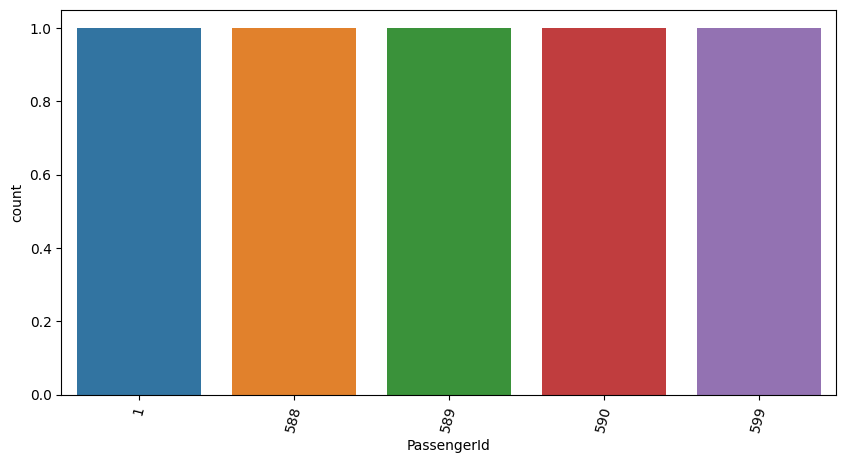

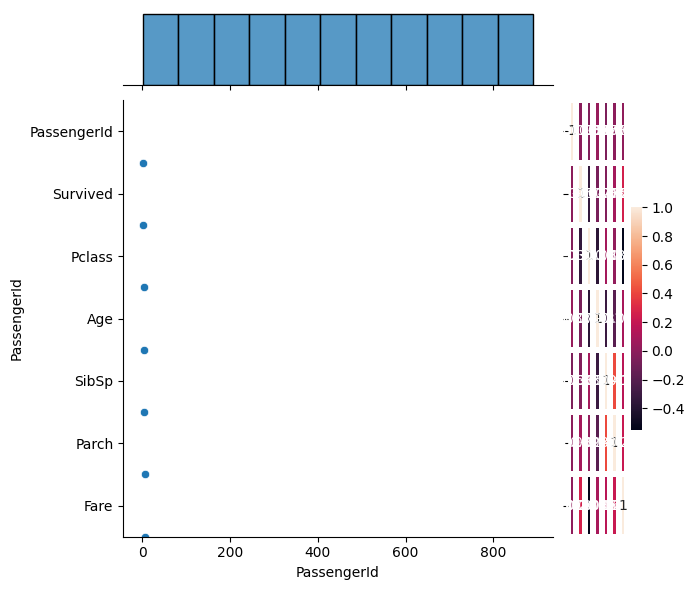

Pair Plot:



Output()


Pie Plot:



interactive(children=(Dropdown(description='Columns:', options=('Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'),…

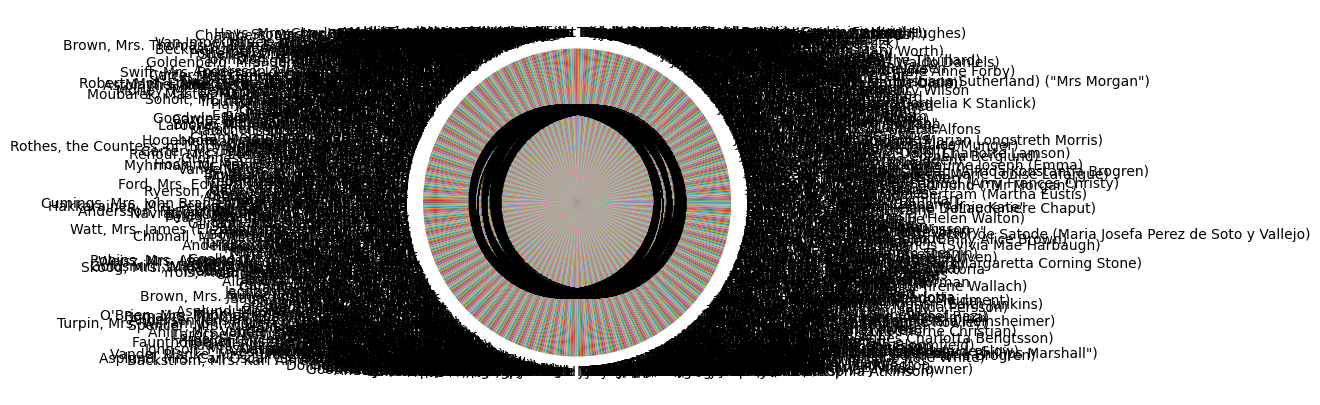

In [43]:
ed = Mleda(df)

In [44]:
re = MlReport(df)


Sample of Dataframe:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
375,376,1,1,"Meyer, Mrs. Edgar Joseph (Leila Saks)",female,NaN,1,0,PC 17604,82.1708,NaN,C
445,446,1,1,"Dodge, Master. Washington",male,4.0,0,2,33638,81.8583,A34,S
315,316,1,3,"Nilsson, Miss. Helmina Josefina",female,26.0,0,0,347470,7.8542,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0000,NaN,S
486,487,1,1,"Hoyt, Mrs. Frederick Maxfield (Jane Anne Forby)",female,35.0,1,0,19943,90.0000,C93,S
279,280,1,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.0,1,1,C.A. 2673,20.2500,NaN,S
528,529,0,3,"Salonen, Mr. Johan Werner",male,39.0,0,0,3101296,7.9250,NaN,S
291,292,1,1,"Bishop, Mrs. Dickinson H (Helen Walton)",female,19.0,1,0,11967,91.0792,B49,C
761,762,0,3,"Nirva, Mr. Iisakki Antino Aijo",male,41.0,0,0,SOTON/O2 3101272,7.1250,NaN,S
301,302,1,3,"McCoy, Mr. Bernard",male,NaN,2,0,367226,23.2500,NaN,Q


Shape of DataFrame:  (891, 12)

Categorical columns: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

Numerical columns: ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

There are total 5 categorical and 7 numerical columns

Uniquess information of Dataset:



,column,unique_count,unique_percent
0,PassengerId,891,100.000000
1,Survived,2,0.224467
2,Pclass,3,0.336700
3,Name,891,100.000000
4,Sex,2,0.224467
5,Age,88,9.876543
6,SibSp,7,0.785634
7,Parch,7,0.785634
8,Ticket,681,76.430976
9,Fare,248,27.833895


You can access this dataframe by typing '<report_obj>.unique_df'
To drop column with particular or minimum threshold use 'mlutils.drop_column_based_on_uniqueness_threshold(df, threshold=0)'

Description of Data:



,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200



Null Information of Dataframe: 


There are total 3 columns having null values out of 12 columns in dataframe



,column_name,null_rows,null_percentage
0,Cabin,687,77.104377
1,Age,177,19.865320
2,Embarked,2,0.224467
